# Two-ion Vibrationally Assisted Energy Transport (VAET)

In [3]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot;

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

## Background

In {cite}`PhysRevX.8.011038` it is demonstrated that two ions in a Paul trap can be used to simulate the following Hamiltonian:

$$
{
\hat{H} = \underbrace{\frac{J}{2} \hat{\sigma}_x^{(1)} \otimes  \hat{\sigma}_x^{(2)}}_{\hat{H}_{S-S}} + \underbrace{\frac{\Delta}{2}  \hat{\sigma}_z^{(2)}}_{\hat{H}_{S}} + 
\underbrace{\frac{\kappa}{2}  \hat{\sigma}_z^{(2)} \otimes (\hat{a} + \hat{a}^{\dagger})}_{\hat{H}_{S-B}} + 
\underbrace{\nu_{eff} \hat{a}^{\dagger}\hat{a}}_{\hat{H}_{B}}
}
$$ (vaet-hamiltonian)

whose dynamics are capable of exhibiting a phenomenon known as *vibrationally assisted energy transport* (VAET). 

For an initial state $|\uparrow \downarrow\rangle$, the effect of $\hat{H}_{S-S}$ is to drive population exchange between the states $|\uparrow \downarrow\rangle \leftrightarrow |\downarrow \uparrow\rangle$ at a rate $J/2$. 

$\hat{H}_{S}$ acts as an energy barrier to this exchange with a strength $\Delta$. If $\Delta$ becomes comparable in magnitude to $J$, then population exchange will be highly suppressed. 

$\hat{H}_{S-B}$ couples the 2$^{nd}$ spin to the vibrational mode -- whose self-energy is described by $\hat{H}_{B}$. Even when the energy barrier to spin transitions is large ($\Delta \gg J$), if also $\nu_{eff} \approx \Delta$, then population transfer between the spins can still be achieved by effectively borrowing or storing energy in the coupled vibrational mode. This is the basis of VAET.

In this notebook, we do a step-by-step walkthrough on how to simulate this effect using IonSim.

## $\hat{H}_{S-S}$

#### Engineering the spin-spin coupling term

In the lab, $\hat{H}_{S-S}$ can be engineered with two laser tones, using a Mølmer-Sørensen type interaction {cite}`PhysRevA.62.022311`, as in [this example](./ramped_molmer_sorensen.ipynb), but now in the off-resonant limit: $\eta_i \Omega \ll |\nu_i-\delta|$, which gives: 

$$
\hat{H}_{S-S} = \frac{(\eta\Omega)^2}{2(\nu-\delta)} \hat{\sigma}_x^{(1)} \otimes  \hat{\sigma}_x^{(2)}
$$ (spin-spin)

```{dropdown} Variable definitions:
* $\pmb{\Omega}$: Characterizes the strength of the ion-light interaction, which we assume to be identical for both lasers.
* $\pmb{\eta}$: Denotes the *Lamb-Dicke* factor, which characterizes the strength with which the laser interaction couples the ion's motion to its electronic states.
* $\pmb{\delta}$: The two lasers, with frequencies $\omega_i$, are detuned from the ion's participating electronic transition frequency $\omega_a$ as $\omega_i-\omega_a=\pm\delta$. 
```

### Construct the system

In [33]:
C = Ca40(["S-1/2", "D-1/2"])
L1 = Laser(pointing=[(1, 1.), (2, 1.)])
L2 = Laser(pointing=[(1, 1.), (2, 1.)])
chain = LinearChain(
        ions=[C, C], com_frequencies=(x=3e6,y=3e6,z=1e6), 
        vibrational_modes=(x=[1], z=[1])
    )
T = Trap(configuration=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2])

axial_mode = T.configuration.vibrational_modes.z[1]
radial_mode = T.configuration.vibrational_modes.x[1]

# Set Hilbert space dimension for participating vibrational modes
axial_mode.N = 5
radial_mode.N = 5;

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/ion_configurations.jl:160


### Set the laser parameters

In [34]:
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
ϵ = 40e3

L1.Δ = Δf + axial_mode.ν + ϵ 
L1.k = ẑ
L1.ϵ = x̂

L2.Δ = Δf - axial_mode.ν - ϵ
L2.k = ẑ
L2.ϵ = x̂

η = abs(get_η(axial_mode, L1, C))
Ω = √(1e3 * ϵ) / η  # This will give a 1kHz MS strength, since coupling goes like (ηΩ)^2/ϵ

Efield_from_rabi_frequency!(Ω, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω, T, 2, 1, ("S-1/2", "D-1/2"));

### Construct Hamiltonian / Solve system

In [35]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1e6);
tout, sol_res = timeevolution.schroedinger_dynamic(
        0:2:3000, C["D-1/2"] ⊗ C["S-1/2"] ⊗ axial_mode[0] ⊗ radial_mode[0], h
    );

In [36]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1e6);

In [37]:
@time tout, sol_res = timeevolution.schroedinger_dynamic(
        0:2:3000, C["D-1/2"] ⊗ C["S-1/2"] ⊗ axial_mode[0] ⊗ radial_mode[0], h
    );

  0.391062 seconds (10.22 M allocations: 315.648 MiB, 10.62% gc time)


### Plot results

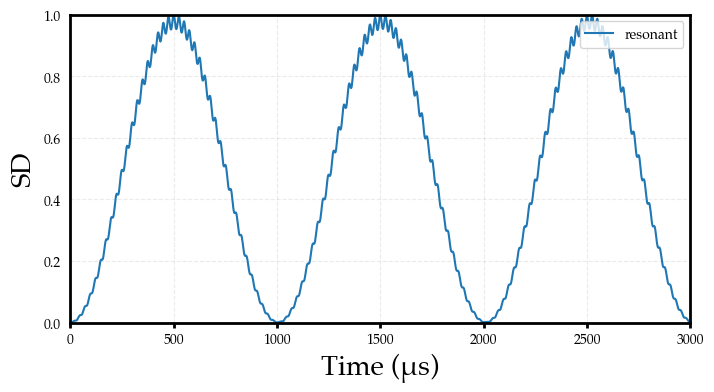

In [38]:
SD_res = expect(ionprojector(T, "S-1/2", "D-1/2"), sol_res)
plt.plot(tout, SD_res, label="resonant")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("SD")
plt.xlabel("Time (μs)");

## $\hat{H}_{S-S} + \hat{H}_{S}$

### Engineering the energy barrier

$\hat{H}_{S} = \frac{\Delta}{2}  \hat{\sigma}_z^{(2)}$ can be engineered via an AC stark shift, B-field gradient or directly in IonSim with the `stark_shift` field of an `Ion`.

In [40]:
# We'll add the barrier term by setting a nonzero value to 
# the trap's B-field gradient:
set_gradient!(T, (1, 2), ("S-1/2", "D-1/2"), √5.25 * 1e3); 
# ΩMS = 1 kHz, so setting Δ = √5.25 kHz gives Ω' = √(ΩMS^2 + Δ^2) = 2.5 kHz

### Construct Hamiltonian / Solve system

In [41]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1e6);

In [42]:
@time tout, sol_det = timeevolution.schroedinger_dynamic(
        0:2:3000, 
        C["D-1/2"] ⊗ C["S-1/2"] ⊗ axial_mode[0] ⊗ radial_mode[0], h
    );

  0.377908 seconds (9.91 M allocations: 305.981 MiB, 9.93% gc time)


### Plot results

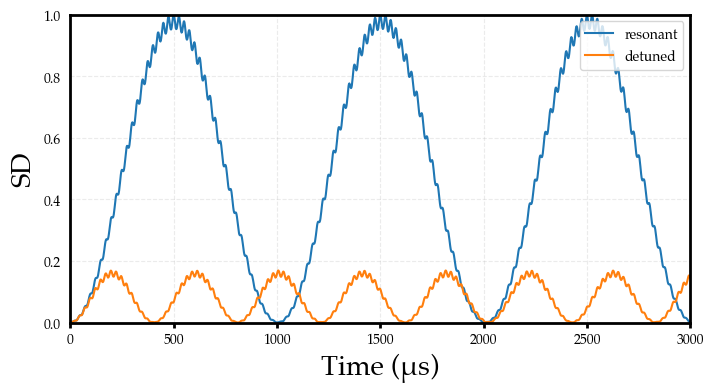

In [43]:
SD_det = expect(ionprojector(T, "S-1/2", "D-1/2"), sol_det)
plt.plot(tout, SD_res, label="resonant")
plt.plot(tout, SD_det, label="detuned")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("SD")
plt.xlabel("Time (μs)");

(vaet-simulation)=
## $\hat{H}_{S-S} + \hat{H}_{S} + \hat{H}_{S-B} + \hat{H}_{B}$

### Engineering the vibrational mode coupling

The spin-bath coupling term can be engineered using two additional laser tones, in a way similar to the Mølmer Sørensen interaction, but shining on only a single ion and with the detunings from the carrier transition equal to plus/minus half of the frequency of the coupled vibrational mode {cite}`PhysRevA.77.050303`. This gives:

$$
\hat{H}_{S-B} = \frac{\eta_i \Omega^2}{2\nu_i}  \hat{\sigma}_z^{(2)} \otimes (\hat{a} + \hat{a}^{\dagger}) + \nu_{eff} \hat{a}^{\dagger}\hat{a}
$$ (spin-boson)

Here $\Omega, \eta$ and $\nu$ are defined as before, $\hat{a}$ is the annihilation for the coupled vibrational mode and $\nu_{eff}$ is controlled by a small asymmetry in the detunings of the two participating lasers (as described in {cite}`PhysRevX.8.011038`).

#### setup two additional lasers for the S-B Hamiltonian

In [44]:
L3 = Laser(pointing=[(2, 1.)])
L4 = Laser(pointing=[(2, 1.)])
T.lasers = [L1, L2, L3, L4];

#### Set the parameters for these new lasers

In [45]:
axial_mode = T.configuration.vibrational_modes.z[1]
radial_mode = T.configuration.vibrational_modes.x[1]

Δf = transition_frequency(T, 2, ("S-1/2", "D-1/2"))
νeff = √5.25 * 1e3

# We set the effective vibrational frequency by detuning 
# the 2-photon transition off resonance
L3.Δ = Δf + radial_mode.ν / 2 + νeff  
L3.k = x̂
L3.ϵ = ẑ

L4.Δ = Δf - radial_mode.ν / 2
L4.k = x̂
L4.ϵ = ẑ

η = abs(get_η(radial_mode, L3, C))
Ω = √((0.5e3 * radial_mode.ν) / η)  # Set κ = 0.5 kHz, since κ = ηΩ^2/ν

Efield_from_rabi_frequency!(Ω, T, 3, 2, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω, T, 4, 2, ("S-1/2", "D-1/2"));

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/lasers.jl:84
┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/lasers.jl:84


(vaet-simulation-solve)=
### Construct Hamiltonian / Solve system

In [46]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1.51e6);

In [47]:
@time tout, sol_vaet = timeevolution.schroedinger_dynamic(
        0:2:3000, 
        C["D-1/2"] ⊗ C["S-1/2"] ⊗ axial_mode[0] ⊗ radial_mode[0], h
    );

 39.174075 seconds (822.95 M allocations: 29.435 GiB, 9.74% gc time)


### Plot results

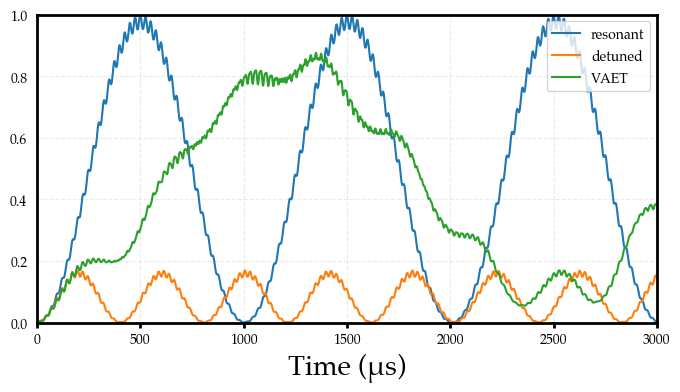

In [48]:
SD_vaet = expect(ionprojector(T, "S-1/2", "D-1/2"), sol_vaet)
plt.plot(tout, SD_res, label="resonant")
plt.plot(tout, SD_det, label="detuned")
plt.plot(tout, SD_vaet, label="VAET")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");

## Bibliography

```{bibliography} two_ion_vaet.bib
:filter: docname in docnames
```